In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.ion()
%matplotlib inline

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions
from ssm.observations import IndependentAutoRegressiveObservations
from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Set the output directory
results_dir = os.path.join("results", "kato", "2018-08-13", "inputdriven")

In [3]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]

K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [4]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
M = 4
pca, xs = pca_with_imputation(M, ys, ms)
xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
lim = 1.1 * abs(np.vstack(xs)).max()

# Split the data into chunks, some train and some test

In [5]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_xs = []
all_ms = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, x, m, ztr) in enumerate(zip(ys, xs, ms, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_xs.append(x[start:stop])
        all_ms.append(m[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_xs = get(all_xs, 0)
train_ms = get(all_ms, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_xs = get(all_xs, 1)
val_ms = get(all_ms, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_xs = get(all_xs, 2)
test_ms = get(all_ms, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_tags, 2)

In [6]:
print(train_tags)
print(val_tags)
print(test_tags)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]


In [7]:
# Set the number of discrete states
Ks = np.arange(2, 14+1, 2, dtype=int)
# etas = [1e-2, 1e-4, 1e-6, 1e-8]
etas = [1e-4]

# Fit standard AR models to the training data

In [8]:
def _fit_standard_hmm(K):
#     standard_hmm = HMM(K, N, M, transitions="inputdriven", observations="independent_ar")
    init_state_distn = InitialStateDistribution(K, N, M)
    transition_distn = InputDrivenTransitions(K, N, M)
#     transition_distn = RecurrentTransitions(K, N, M)
    observation_distn = IndependentAutoRegressiveObservations(K, N, 0)
    standard_hmm = _HMM(K, N, M, init_state_distn, transition_distn, observation_distn)

    
#     standard_hmm = HMM(K, N, M, transitions="recurrent", observations="independent_ar")
    train_lls = standard_hmm.fit(train_ys, inputs=train_xs, masks=train_ms, method="em", num_em_iters=50)
    val_ll = standard_hmm.log_probability(val_ys, masks=val_ms)
    return standard_hmm, train_lls, val_ll

In [9]:
# Fit an HMM with a single set of dynamics
standard_hmms = []
standard_train_lls = []
standard_val_lls = []
for K in Ks:
    print("Fitting model with {} states".format(K))
    _fit = cached(results_dir, "standard_hmm_{}".format(K))(partial(_fit_standard_hmm, K))
    standard_hmm, train_lls, val_ll = _fit()
    standard_hmms.append(standard_hmm)
    standard_train_lls.append(train_lls)
    standard_val_lls.append(val_ll)

Fitting model with 2 states
Fitting model with 4 states
Fitting model with 6 states
Fitting model with 8 states
Fitting model with 10 states
Fitting model with 12 states
Fitting model with 14 states


Text(0,0.5,'Validation LL')

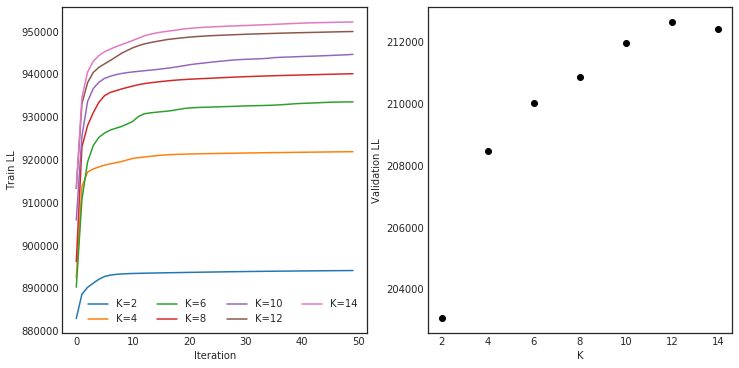

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
for K,lls in zip(Ks, standard_train_lls):
    plt.plot(lls, label="K={}".format(K))
plt.xlabel("Iteration")
plt.ylabel("Train LL")
plt.legend(loc="lower right", ncol=4)


plt.subplot(122)
for K, val_ll in zip(Ks, standard_val_lls):
    plt.plot(K, val_ll, 'ko')
plt.xticks(Ks)
plt.xlabel("K")
plt.ylabel("Validation LL")

# Fit hierarchical HMMs

In [11]:
def _make_hierarchical_hmm(K, standard_hmm, eta):
    # Fit a hierarchical hmm
    init_state_distn = InitialStateDistribution(K, N, M)
#     transition_distn = StationaryTransitions(K, N, M)
    transition_distn = InputDrivenTransitions(K, N, M)
#     transition_distn = RecurrentTransitions(K, N, M)
    observation_distn = HierarchicalIndependentAutoRegressiveObservations(K, N, W, 0, eta=eta)
    hmm = _HMM(K, N, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hmm.init_state_distn.params = copy.deepcopy(standard_hmm.init_state_distn.params)
    hmm.transitions.params = copy.deepcopy(standard_hmm.transitions.params)

    hmm.observations.shared_As = standard_hmm.observations.As.copy()
    hmm.observations.shared_Vs = standard_hmm.observations.Vs.copy()
    hmm.observations.shared_bs = standard_hmm.observations.bs.copy()

    for w in range(W):
        hmm.observations.As[w] = standard_hmm.observations.As.copy()
        hmm.observations.Vs[w] = standard_hmm.observations.Vs.copy()
        hmm.observations.bs[w] = standard_hmm.observations.bs.copy()
        hmm.observations.inv_sigmas[w] = standard_hmm.observations.inv_sigmas.copy()
    
    assert np.allclose(
        standard_hmm.log_probability(train_ys, masks=train_ms),
        hmm.log_probability(train_ys, masks=train_ms, tags=train_tags)
    )

    return hmm

def _fit_hierarchical_hmm(K, standard_hmm, eta):
    hmm = _make_hierarchical_hmm(K, standard_hmm, eta)
    train_lls = hmm.fit(train_ys, masks=train_ms, tags=train_tags, method="em", num_em_iters=50)
    val_ll = hmm.log_probability(val_ys, masks=val_ms, tags=val_tags)
    return hmm, train_lls, val_ll

In [12]:
# Fit the hierarchical HMM
hierarchical_hmms = np.zeros((len(Ks), len(etas)), dtype=object)
hierarchical_train_lls = np.zeros((len(Ks), len(etas), 50))
hierarchical_val_lls = np.zeros((len(Ks), len(etas)))
for i, (K, standard_hmm) in enumerate(zip(Ks, standard_hmms)):
    for j, eta in enumerate(etas):
        print("Fitting model with {} states and eta = {:.0e}".format(K, eta))
        results_file = "hierarchical_hmm_K{}_eta{:.0e}".format(K, eta)
        _fit = cached(results_dir, results_file)(_fit_hierarchical_hmm)
        hmm, train_lls, val_ll = _fit(K, standard_hmm, eta)
        
        hierarchical_hmms[i, j] = hmm
        hierarchical_train_lls[i, j] = train_lls
        hierarchical_val_lls[i, j] = val_ll

Fitting model with 2 states and eta = 1e-04
Fitting model with 4 states and eta = 1e-04
Fitting model with 6 states and eta = 1e-04
Fitting model with 8 states and eta = 1e-04
Fitting model with 10 states and eta = 1e-04
Fitting model with 12 states and eta = 1e-04
Fitting model with 14 states and eta = 1e-04


(200000, 215000)

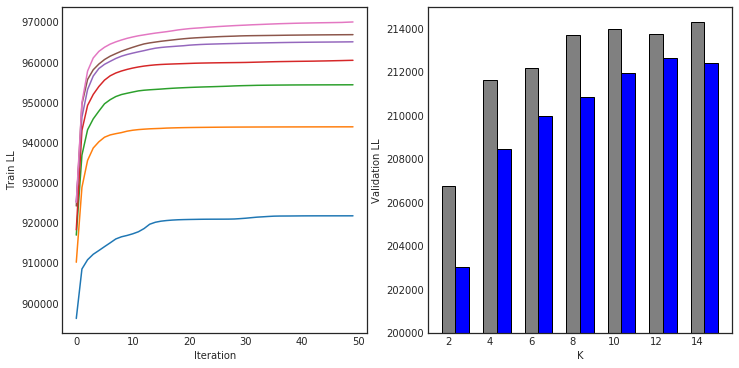

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
for i, K in enumerate(Ks):
    for j, eta in enumerate(etas):
        plt.plot(hierarchical_train_lls[i, j], label="K={}, eta={:.0e}".format(K, eta))
plt.xlabel("Iteration")
plt.ylabel("Train LL")
# plt.legend(loc="lower right", ncol=4)

plt.subplot(122)
width = 2/(len(etas) + 2)
for i, K in enumerate(Ks):
    for j, eta in enumerate(etas):
        plt.bar(K + j*width, hierarchical_val_lls[i, j], width=width, color="gray", edgecolor='k')
    plt.bar(K + len(etas)*width, standard_val_lls[i], width=width, color='b', edgecolor='k')
plt.xticks(Ks)
plt.xlabel("K")
plt.ylabel("Validation LL")
plt.ylim(200000, 215000)

# Choose the model size based on the knee in the xv curve

In [14]:
hmm = hierarchical_hmms[Ks==8][0, np.array(etas) == 1e-4][0]
# hmm = standard_hmms[np.where(Ks==8)[0][0]]

# Fit the model to the entire dataset

In [15]:
# zs = [standard_hmm.most_likely_states(y, mask=m) for y, m in zip(ys, ms)]
# standard_hmm.permute(find_permutation(np.concatenate(zs), np.concatenate(z_trues)))
# zs = [standard_hmm.most_likely_states(y, mask=m) for y, m in zip(ys, ms)]

In [16]:
zs = [hmm.most_likely_states(y, mask=m, tag=tag) for y, m, tag in zip(ys, ms, range(W))]
hmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(zs)))
zs = [hmm.most_likely_states(y, mask=m, tag=tag) for y, m, tag in zip(ys, ms, range(W))]

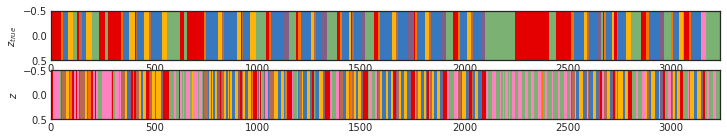

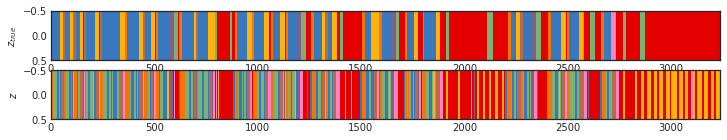

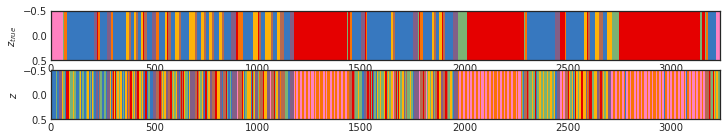

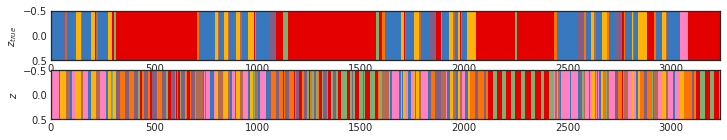

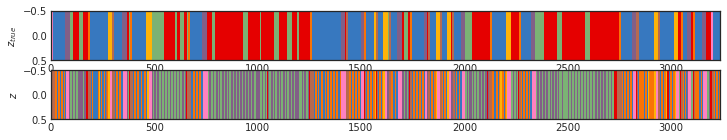

In [17]:
for w in range(W):
    plt.figure(figsize=(12, 2))

    plt.subplot(211)
    plt.imshow(z_trues[w][None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
    plt.ylabel("$z_{true}$")

    plt.subplot(212)
    plt.imshow(zs[w][None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
    plt.ylabel("$z$")

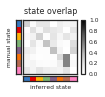

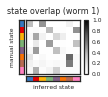

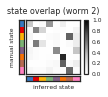

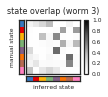

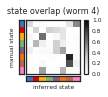

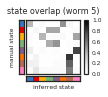

In [18]:
zplt.plot_state_overlap(zs, z_trues)

In [19]:
# E_z, E_zzp1 = hmm.expected_states(ys[0], mask=ms[0], tag=0)
# plt.imshow(E_z.T, aspect="auto", vmin=0, vmax=1)
# plt.colorbar()

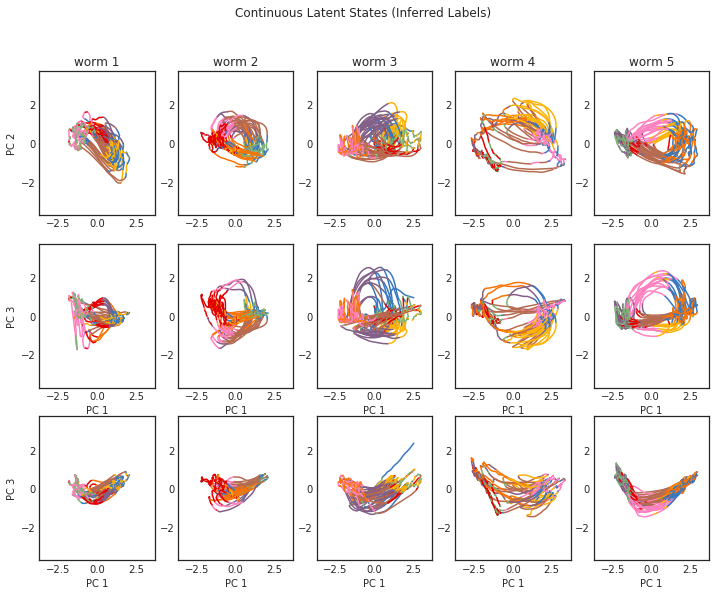

In [20]:
plt.figure(figsize=(12, 9))

for w in range(W):
    ax = plt.subplot(3, W, w+1)
    zplt.plot_2d_continuous_states(xs[w], zs[w], xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.title("worm {}".format(w+1))

    ax = plt.subplot(3, W, W+w+1)
    zplt.plot_2d_continuous_states(xs[w], zs[w], xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")

    ax = plt.subplot(3, W, 2 * W+w+1)
    zplt.plot_2d_continuous_states(xs[w], zs[w], xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")

    plt.suptitle("Continuous Latent States (Inferred Labels)")

# Simulate from the model with the inferred discrete states

In [21]:
# z_smpl = np.array([superhmm.observations.sample_x(st, None) for st in s])  # T x N_valid
w = 0
z_smpl = zs[w].copy()
y_smpl = np.zeros((Ts[w], N))
for t in range(Ts[w]):
    y_smpl[t] = hmm.observations.sample_x(z_smpl[t], y_smpl[:t], tag=w, with_noise=False)

In [22]:
# Throw out the unstable samples
bad = np.where(abs(y_smpl).max(0) > 3)[0]
y_good = y_smpl.copy()
y_good[:, bad] = np.nan
print("neurons with bad simulations: ", bad)

neurons with bad simulations:  []


Text(0.5,0,'time (s)')

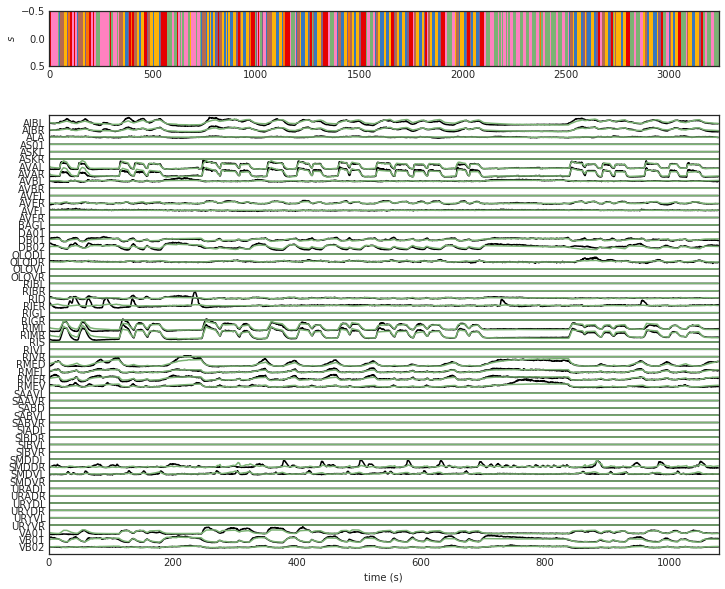

In [23]:
# Plot real data for comparison
plt.figure(figsize=(12, 10))
gs = GridSpec(2, 1, height_ratios=[1, 8])


plt.subplot(gs[0])
plt.imshow(z_smpl[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$s$")

plt.subplot(gs[1])
plt.plot(np.arange(Ts[w]) / 3.0, ys[w] - np.arange(N), '-k')
plt.plot(np.arange(Ts[w]) / 3.0, y_good - np.arange(N), '-', color=zplt.default_colors[3])
plt.yticks(-np.arange(N), neuron_names)
plt.ylim(-N,1)
plt.xlim(0, Ts[w] / 3.0)
plt.xlabel("time (s)")

# Simulate complete dataset

In [24]:
# z_smpl = np.array([superhmm.observations.sample_x(st, None) for st in s])  # T x N_valid
w = 0
z_smpl, y_smpl = hmm.sample(3239, tag=w)

ValueError: could not broadcast input array from shape (8,59) into shape (59)

In [ ]:
# Plot real data for comparison
plt.figure(figsize=(12, 10))
gs = GridSpec(2, 1, height_ratios=[1, 8])


plt.subplot(gs[0])
plt.imshow(z_smpl[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$s$")

plt.subplot(gs[1])
plt.plot(np.arange(Ts[w]) / 3.0, y_smpl - np.arange(N), '-', color=zplt.default_colors[3])
plt.yticks(-np.arange(N), neuron_names)
plt.ylim(-N,1)
plt.xlim(0, Ts[w] / 3.0)
plt.xlabel("time (s)")